In [1]:
import sys
import time
import warnings

sys.path.insert(0, "..")

import gpflow
import numpy as np
import tensorflow as tf
# import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from osvgp.models import OSGPR

rng = np.random.RandomState(69)
tf.random.set_seed(69)
plt.style.use("seaborn")
warnings.filterwarnings("ignore")

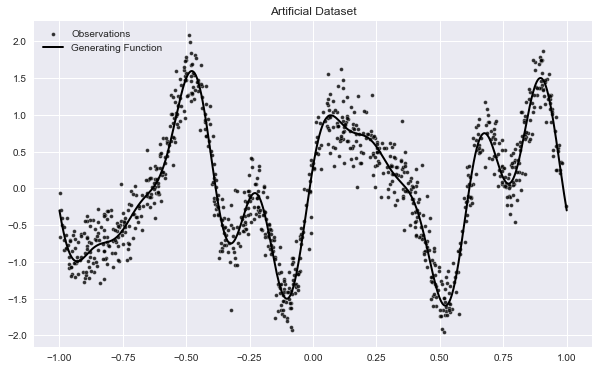

In [2]:
def func(x):
    return np.sin(x*3* np.pi) + 0.3*np.cos(x*9*np.pi) + 0.5*np.sin(x*7*np.pi)

# Number of training observations and noise scale
N = 1000
sigma_n = 0.25
noise_var = sigma_n**2

# Inputs and (noisy) outputs
X = rng.rand(N, 1) * 2 - 1 
y = func(X) + sigma_n * rng.randn(N, 1) 
data = (X, y)

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(np.linspace(-1.0, 1.0, 1000), func(np.linspace(-1.0, 1.0, 1000)), lw=2, 
        label="Generating Function", c="k")
ax.set_title("Artificial Dataset")
ax.legend()
plt.show()

In [3]:
# Initialise inducing points
Mu = 20
Mv = 20
Z = rng.rand(Mu, 1)
O = rng.rand(Mv, 1) - 1
inducing_inputs = (Z, O)

# Set kernel
kernel = gpflow.kernels.SquaredExponential()

# Initialise the SGPR model
solve_gp = OSGPR(data, kernel, inducing_inputs, noise_var, "SOLVE-GP")
odvgp = OSGPR(data, kernel, inducing_inputs, noise_var, "ODVGP")

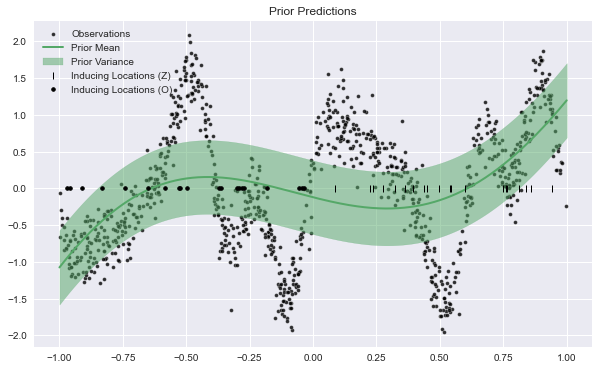

In [4]:
# Prior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
solve_gp_prior_mean, solve_gp_prior_var = solve_gp.predict_y(X_pred)
Z, O = solve_gp.Z[:, 0], solve_gp.O[:, 0]

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], solve_gp_prior_mean[:, 0], c="C1", lw=2, label="Prior Mean")
ax.fill_between(X_pred[:, 0], solve_gp_prior_mean[:, 0] + 2*np.sqrt(solve_gp_prior_var[:, 0]), 
                solve_gp_prior_mean[:, 0] - 2*np.sqrt(solve_gp_prior_var[:, 0]), color="C1", 
                alpha=0.5, label="Prior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations (Z)")
ax.plot(O, np.zeros_like(O), "k.", mew=1, label="Inducing Locations (O)")
ax.set_title("Prior Predictions")
ax.legend()
plt.show()

In [5]:
print(solve_gp.elbo())
optimiser = gpflow.optimizers.Scipy()
optimiser.minimize(solve_gp.training_loss, 
                   solve_gp.trainable_variables,
                   options={"maxiter": 1000, "disp": False})                 
print(solve_gp.elbo())

tf.Tensor(-4393.146095266544, shape=(), dtype=float64)


2022-07-21 16:03:41.149321: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-21 16:03:42.142485: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(-118.22263447788208, shape=(), dtype=float64)


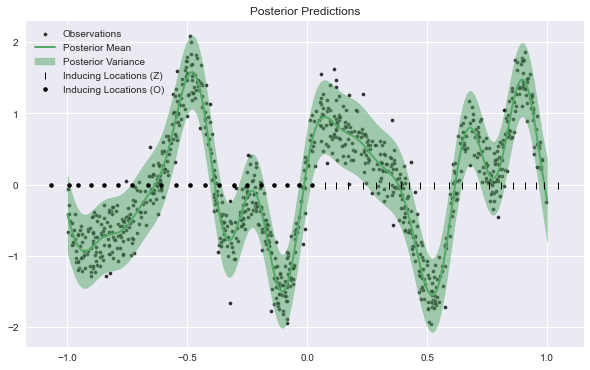

In [6]:
# Posterior evaluations
X_pred = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
solve_gp_post_mean,  solve_gp_post_var = solve_gp.predict_y(X_pred)
Z, O = solve_gp.Z[:, 0], solve_gp.O[:, 0]

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=15, alpha=0.8, 
           label="Observations")
ax.plot(X_pred[:, 0], solve_gp_post_mean[:, 0], c="C1", lw=2, label="Posterior Mean")
ax.fill_between(X_pred[:, 0], solve_gp_post_mean[:, 0] + 2*np.sqrt(solve_gp_post_var[:, 0]), 
                solve_gp_post_mean[:, 0] - 2*np.sqrt(solve_gp_post_var[:, 0]), color="C1", 
                alpha=0.5, label="Posterior Variance")
ax.plot(Z, np.zeros_like(Z), "k|", mew=1, label="Inducing Locations (Z)")
ax.plot(O, np.zeros_like(O), "k.", mew=1, label="Inducing Locations (O)")
ax.set_title("Posterior Predictions")
ax.legend()
plt.show()

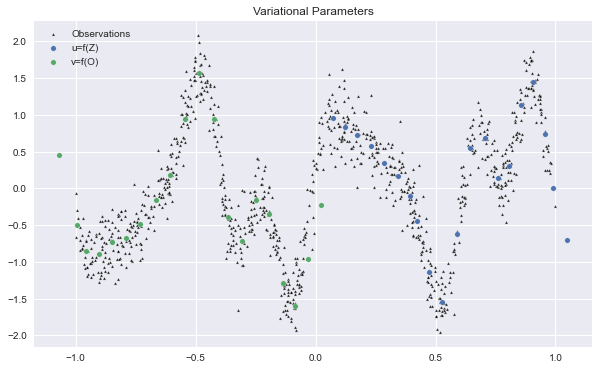

In [7]:
# Variational parameters
Z, O = solve_gp.Z, solve_gp.O
mu, mv = solve_gp.mu, solve_gp.mv
Su, Sv = solve_gp.Su, solve_gp.Sv

# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X, y, facecolor="k", edgecolor="w", s=10, alpha=0.8, 
           marker="^",label="Observations")
ax.scatter(Z, mu, facecolor="C0", edgecolor="w", s=30, label="u=f(Z)")
ax.scatter(O, mv, facecolor="C1", edgecolor="w", s=30, label="v=f(O)")
ax.set_title("Variational Parameters")
ax.legend()
plt.show()